In [74]:
%load_ext autoreload
%autoreload 2
import sys
import os
dir_ = os.path.dirname(os.getcwd())
if dir_ not in sys.path:
    sys.path.append(dir_)
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from comet_ml import Experiment
from comet_ml import API

from sklearn.model_selection import train_test_split
sns.set_theme()

from ift6758.models.utils import preprocess, predict_model,save_metrics_and_models_on_comet,compute_metrics
from ift6758.models.plotter import *
from dotenv import load_dotenv

from sklearn.neural_network import MLPClassifier
from sklearn.utils import resample , shuffle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
url = 'https://drive.google.com/file/d/1kM__riNHRPx5GsyuOH3yhiql3OZvwmuP/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
df = pd.read_csv(path)

In [3]:
df_train = df[df['season']!=20192020]

In [92]:
list_features = ['empty_net', 'periodTime','period', 'x_coord', 'y_coord','distance','angle','shot_type',\
    'last_event_type', 'last_x_coord', 'last_y_coord','distance_from_last', 'seconds_since_last', \
        'rebound', 'angle_change','speed']
list_features = ['empty_net','distance','angle','shot_type']
# preprocess
X, Y ,df_train_preprocessed,_ =  preprocess(df_train,features = list_features, standarize=True)



### Oversampling

In [93]:
X_train, X_val, y_train, y_val = train_test_split(X,Y,random_state = 42, shuffle=True)
X_oversampled, y_oversampled = resample(X_train[y_train == 1],
                                        y_train[y_train == 1],
                                        replace=True,
                                        n_samples=X_train[y_train == 0].shape[0],
                                        random_state=42)

X_train = np.vstack((X_train[y_train == 0], X_oversampled))
y_train = np.hstack((y_train[y_train == 0], y_oversampled))
X_train, y_train = shuffle(X_train,y_train,random_state=42)

### Undersampling

In [77]:
X_train, X_val, y_train, y_val = train_test_split(X,Y,random_state = 42, shuffle=True)
X_undersampled, y_undersampled = resample(X_train[y_train == 0],
                                          y_train[y_train == 0],
                                          replace=True,
                                          n_samples=X_train[y_train == 1].shape[0],
                                           random_state=42)
X_train = np.vstack((X_train[y_train == 1], X_undersampled))
y_train = np.hstack((y_train[y_train == 1], y_undersampled))
X_train, y_train = shuffle(X_train,y_train,random_state=42)

In [94]:
model = MLPClassifier(hidden_layer_sizes=(100,50,20),warm_start=True,random_state=1, max_iter=200,verbose=True)

In [95]:
model.fit(X_train, y_train)
y_val_prob = model.predict_proba(X_val)
y_val_pred = model.predict(X_val)

df_metrics_results = compute_metrics(y_val,[y_val_pred],model_names=['NN'])
df_metrics_results

Iteration 1, loss = 0.58732251
Iteration 2, loss = 0.58354205
Iteration 3, loss = 0.58265566
Iteration 4, loss = 0.58178136
Iteration 5, loss = 0.58111582
Iteration 6, loss = 0.58052602
Iteration 7, loss = 0.58014766
Iteration 8, loss = 0.57984403
Iteration 9, loss = 0.57950730
Iteration 10, loss = 0.57926858
Iteration 11, loss = 0.57887265
Iteration 12, loss = 0.57872762
Iteration 13, loss = 0.57844396
Iteration 14, loss = 0.57831974
Iteration 15, loss = 0.57813331
Iteration 16, loss = 0.57793503
Iteration 17, loss = 0.57761895
Iteration 18, loss = 0.57752713
Iteration 19, loss = 0.57731051
Iteration 20, loss = 0.57704639
Iteration 21, loss = 0.57697588
Iteration 22, loss = 0.57681137
Iteration 23, loss = 0.57665420
Iteration 24, loss = 0.57656171
Iteration 25, loss = 0.57630957
Iteration 26, loss = 0.57634882
Iteration 27, loss = 0.57608532
Iteration 28, loss = 0.57603381
Iteration 29, loss = 0.57594720
Iteration 30, loss = 0.57580374
Iteration 31, loss = 0.57581977
Iteration 32, los

,model_name,Accuracy,Recall,Precision,f_score
0,NN,0.651346,0.691259,0.567884,0.52683


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/princesslove/itf-6758-team-4/730725c39e7449d0b6dc9cf2e58335ac

COMET WARNING: Converting metric value ''question6_UnderSampling_NeuralNet'' into a string using str(), resulting string might be invalid
COMET WARNING: Unknown error exporting current conda environment
COMET WARNING: Unknown error retrieving Conda package as an explicit file
COMET WARNING: Unknown error retrieving Conda information
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/princesslove/itf-6758-team-4/730725c39e7449d0b6dc9cf2e58335ac
COMET INFO:   Metrics:
COMET INFO:     AUC        : 0.628

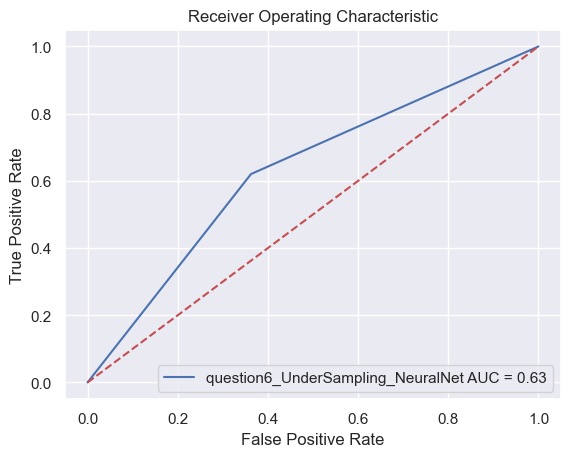

<Figure size 640x480 with 0 Axes>

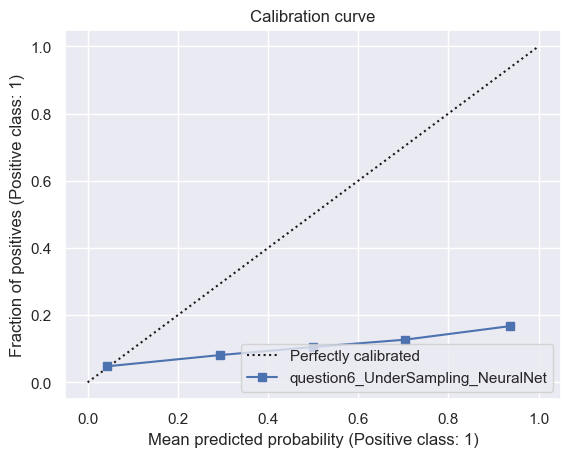

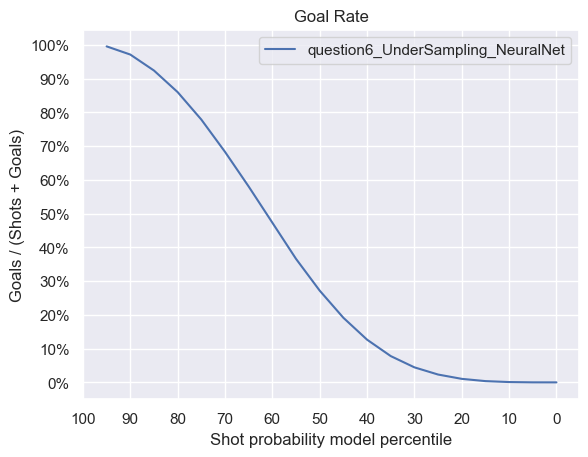

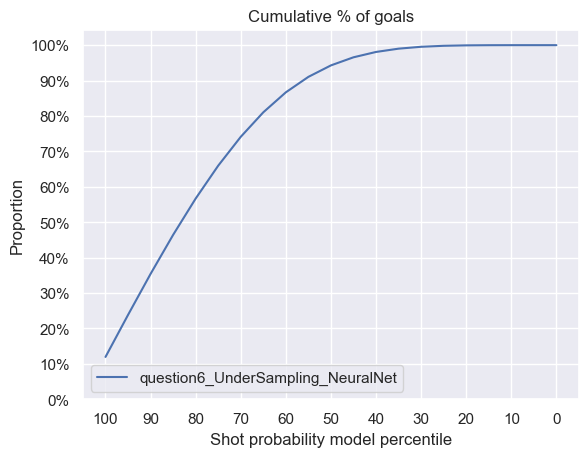

In [81]:
name_experiment = "question6_UnderSampling_NeuralNet"
model_dir = "NN"

save_metrics_and_models_on_comet(clf,y_val,y_val_pred,y_val_prob[:,1],model_names=name_experiment,model_dir=model_dir,name_experiment=name_experiment,register_model = False ,sklearn_model=True)